In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython
import os
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras import layers, models, regularizers
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import seaborn as sb
import random
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Loading the data

- We first load the dataset while mapping each emotion to it's label
- The audio files don't share the same length or quality therefore :
  - we sample all the files with the same sampling rate of 16000
  - we add padding to all audio files to match the largest one. 

In [ ]:
emotionsMap = {"HAP" : 0, "SAD" : 1, "ANG" : 2, "FEA" : 3, "DIS" : 4, "NEU" : 5}

def loadData(datasetPath, samplingRate, length):
  audios = []
  emotions = []
  duration = length * samplingRate
  for audioFile in os.listdir(datasetPath):
    path = datasetPath + "/" + audioFile
    audio, samplingRate = librosa.load(path, sr = samplingRate) 
      
    if len(audio) < duration:
      padding = duration - len(audio)
      offset = padding // 2
      audio = np.pad(audio, (offset,padding - offset), 'constant')
    else:
      audio = audio[:length * samplingRate]  

    audios.append(audio)
    info = audioFile.partition(".wav")[0].split("_")
    emotions.append(emotionsMap[info[2]])
  return np.array(audios), np.array(emotions)


In [ ]:
audios, emotions = loadData("drive/MyDrive/Crema", 16000, 3)

##Understanding Classes

We plotted a sample of each class to get a better grasp on the dataset.

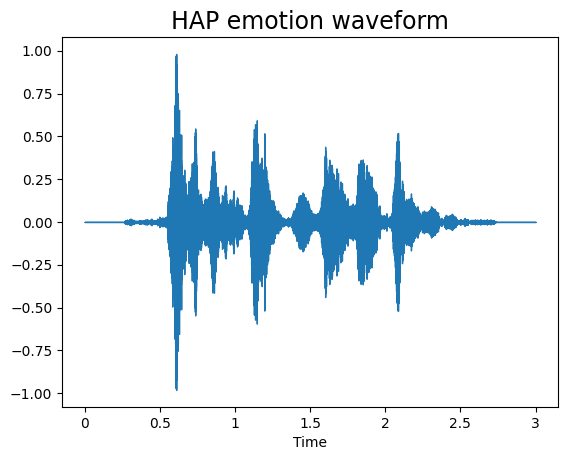

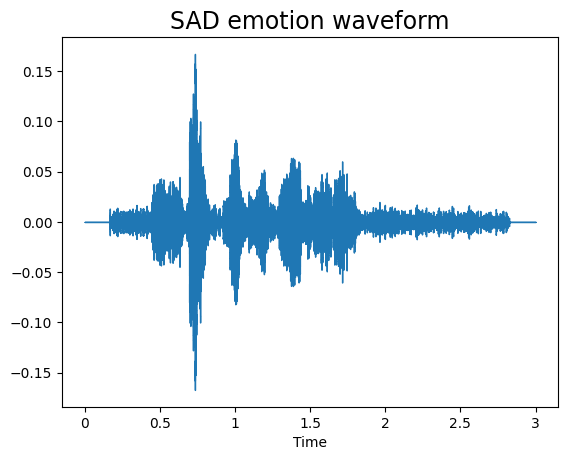

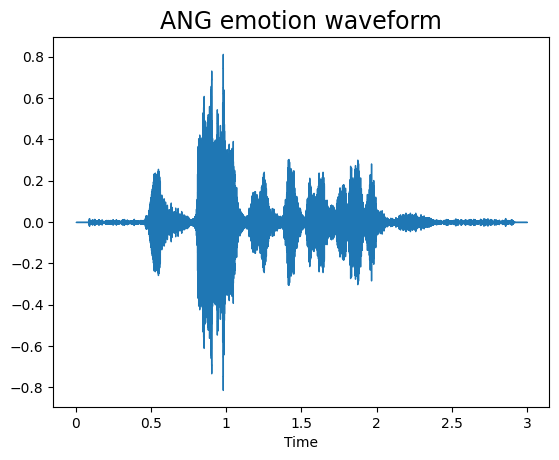

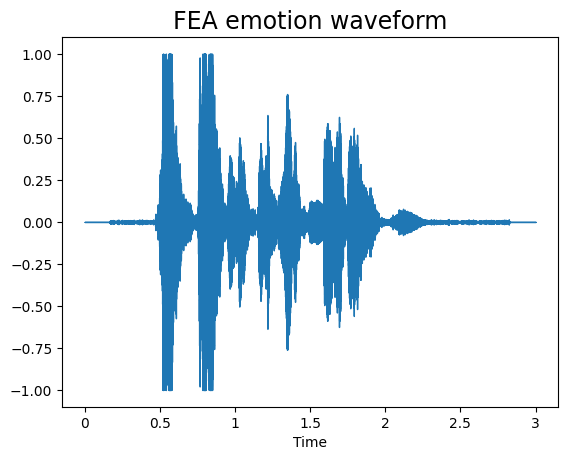

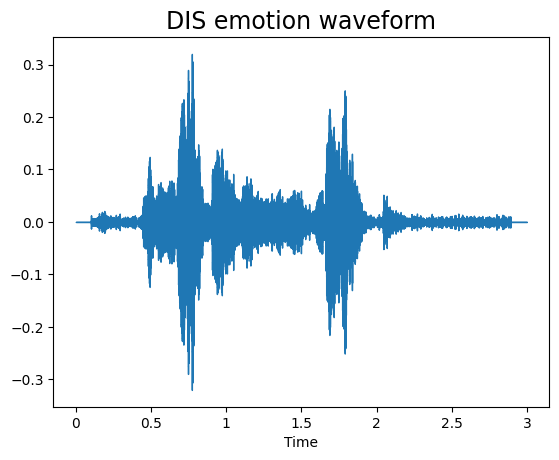

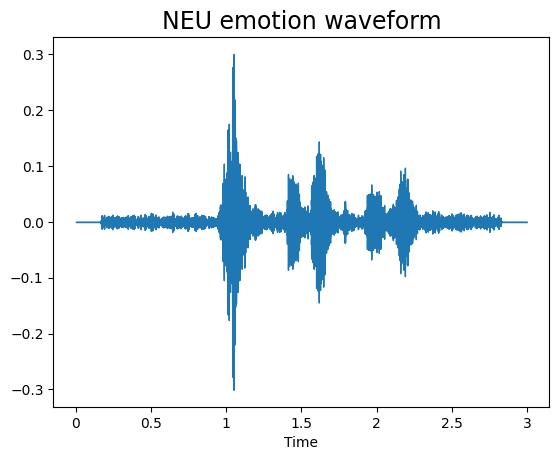

In [ ]:
for emotion in emotionsMap :
  for i in range(len(emotions)):
    if (emotions[i] == emotionsMap[emotion]):
      plt.title(f'{emotion} emotion waveform',size=17)
      librosa.display.waveshow(y = audios[i], sr = samplingRates[i])
      plt.show()
      IPython.core.display.display(IPython.display.Audio(audios[i], rate = samplingRates[i]))
      break
    

##Creating Feature Spaces

For the feature spaces we used:
- For 1d: zero crossing rate, along with the energy.
- For 2d: melspectrogram

In [ ]:
def extract_1d_features(data):
  feature_space = []
  for sample in data:
    zcr = np.squeeze(librosa.feature.zero_crossing_rate(sample))
    ms = np.squeeze(np.power(librosa.feature.rms(y = sample), 2))
    res = np.hstack((zcr, ms))
    feature_space.append(res)
  return np.array(feature_space)

def extract_2d_features(data):
  feature_space = []
  for sample in data:
    spec = librosa.feature.melspectrogram(y=sample, sr=16000)
    feature_space.append(spec)
  feature_space= np.array(feature_space)
  feature_space = feature_space[:,:,:,np.newaxis]
  return feature_space

In [ ]:
data_1d = extract_1d_features(audios)

In [ ]:
data_2d = extract_2d_features(audios)

In [ ]:
print(data_1d.shape)
print(data_2d.shape)
print(emotions.shape)

(7445, 188)
(7445, 128, 94, 1)
(7445,)


#Splitting Data

##1D

In [ ]:
trainData, testData, trainLabels, testLabels = train_test_split(data_1d, emotions, random_state=42, test_size=0.3, shuffle=True)
trainData, validationData, trainLabels, validationLabels = train_test_split(trainData, trainLabels, random_state=42, test_size=0.05, shuffle=True)

print(trainData.shape)
print(trainLabels.shape)
print(testData.shape)
print(testLabels.shape)
print(validationData.shape)
print(validationLabels.shape)

(4950, 188)
(4950,)
(2234, 188)
(2234,)
(261, 188)
(261,)


##2D

In [ ]:
twoDimTrainData, twoDimTestData, twoDimTrainLabels, twoDimTestLabels = train_test_split(data_2d, emotions, random_state=42, test_size=0.3, shuffle=True)
twoDimTrainData, twoDimValidationData, twoDimTrainLabels, twoDimValidationLabels = train_test_split(twoDimTrainData, twoDimTrainLabels, random_state=42, test_size=0.05, shuffle=True)

print(twoDimTrainData.shape)
print(twoDimTrainLabels.shape)
print(twoDimTestData.shape)
print(twoDimTestLabels.shape)
print(twoDimValidationData.shape)
print(twoDimValidationLabels.shape)

(4950, 128, 94, 1)
(4950,)
(2234, 128, 94, 1)
(2234,)
(261, 128, 94, 1)
(261,)


#Creating Models

##1D

In [ ]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        kernel_regularizer=regularizers.l2(0),
                        input_shape=(trainData.shape[1], 1)))

model.add(layers.BatchNormalization())

model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))



model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", kernel_regularizer=regularizers.l2(0.01),
                        activation="relu"))

model.add(layers.BatchNormalization())

model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1,
                        padding="same", kernel_regularizer=regularizers.l2(0.01),
                        activation="relu"))

model.add(layers.BatchNormalization())

model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(128, kernel_size=5, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01),
                        activation='relu'))

model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dropout(0.4))

model.add(layers.Dense(6, activation="softmax"))

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 188, 512)          3072      
                                                                 
 batch_normalization_6 (Batc  (None, 188, 512)         2048      
 hNormalization)                                                 
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 94, 512)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 94, 512)           1311232   
                                                                 
 batch_normalization_7 (Batc  (None, 94, 512)          2048      
 hNormalization)                                                 
                                                      

##2D

In [ ]:
model2D = models.Sequential()

model2D.add(layers.Conv2D(64, kernel_size=3, strides=1,
                       activation="relu",
                       padding="same",
                        input_shape= (128, 94, 1)))

model2D.add(layers.Conv2D(64, kernel_size=3, strides=1,
                      padding="same",
                       activation="relu"))

model2D.add(layers.BatchNormalization())

model2D.add(layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

model2D.add(layers.Conv2D(16, kernel_size = 5, strides=1, padding="same",activation='relu'))


model2D.add(layers.MaxPool2D(pool_size=3, padding="same", strides=2))

model2D.add(layers.Conv2D(16, kernel_size=5, strides=1,
                          padding="same",
                         activation="relu"))

model2D.add(layers.MaxPool2D(pool_size=5, padding="same", strides=2))

model2D.add(layers.Conv2D(128, kernel_size=5, padding="same", strides=1, activation='relu'))

model2D.add(layers.MaxPooling2D(pool_size=5,padding="same", strides = 2))
model2D.add(layers.Flatten())


model2D.add(layers.Dense(256, activation='relu'))

model2D.add(layers.Dropout(0.4))

model2D.add(layers.Dense(6, activation="softmax"))

model2D.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model2D.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 94, 64)       640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 94, 64)       36928     
                                                                 
 batch_normalization_9 (Batc  (None, 128, 94, 64)      256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 47, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 47, 16)        25616     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 24, 16)      

#Training Models

##1D

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor = 0.4, verbose = 1, patience = 2, min_lr = 0.0001)
es = EarlyStopping(monitor="val_accuracy", patience=2, verbose=0)
model_history = model.fit(trainData, trainLabels, batch_size=64, epochs=150, validation_data=(validationData, validationLabels), callbacks=[rlrp])
score, accuracy = model.evaluate(validationData, validationLabels, verbose=0)
print('Validation accuracy:', accuracy)

Epoch 1/150
78/78 [==============================] - 7s 41ms/step - loss: 9.0147 - accuracy: 0.2271 - val_loss: 4.9064 - val_accuracy: 0.1762 - lr: 0.0010
Epoch 2/150
78/78 [==============================] - 2s 30ms/step - loss: 3.3963 - accuracy: 0.2507 - val_loss: 2.7322 - val_accuracy: 0.1762 - lr: 0.0010
Epoch 3/150
78/78 [==============================] - 2s 29ms/step - loss: 2.3395 - accuracy: 0.2719 - val_loss: 2.3977 - val_accuracy: 0.1762 - lr: 0.0010
Epoch 4/150
78/78 [==============================] - 2s 28ms/step - loss: 2.0245 - accuracy: 0.2893 - val_loss: 2.7220 - val_accuracy: 0.1762 - lr: 0.0010
Epoch 5/150
78/78 [==============================] - 2s 28ms/step - loss: 1.8972 - accuracy: 0.2986 - val_loss: 1.9712 - val_accuracy: 0.2414 - lr: 0.0010
Epoch 6/150
78/78 [==============================] - 2s 28ms/step - loss: 1.8173 - accuracy: 0.3180 - val_loss: 2.2878 - val_accuracy: 0.1762 - lr: 0.0010
Epoch 7/150
78/78 [==============================] - 2s 29ms/step - lo

##2D

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor = 0.4, verbose = 1, patience = 2, min_lr = 0.0001)
es = EarlyStopping(monitor="val_accuracy", patience=2, verbose=0)
model_history_2D = model2D.fit(twoDimTrainData, twoDimTrainLabels, batch_size = 64, epochs=100, shuffle=True, validation_data=(twoDimValidationData, twoDimValidationLabels), callbacks=[rlrp])
score2D, accuracy2D = model2D.evaluate(twoDimValidationData, twoDimValidationLabels, verbose=0)
print('Validation accuracy:', accuracy2D)

Epoch 1/100
78/78 [==============================] - 38s 433ms/step - loss: 2.1302 - accuracy: 0.2935 - val_loss: 1.5765 - val_accuracy: 0.3218 - lr: 0.0010
Epoch 2/100
78/78 [==============================] - 6s 73ms/step - loss: 1.4779 - accuracy: 0.3986 - val_loss: 2.0562 - val_accuracy: 0.2644 - lr: 0.0010
Epoch 3/100
78/78 [==============================] - 6s 74ms/step - loss: 1.4109 - accuracy: 0.4255 - val_loss: 1.4692 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 4/100
78/78 [==============================] - 6s 74ms/step - loss: 1.3621 - accuracy: 0.4547 - val_loss: 1.6277 - val_accuracy: 0.3908 - lr: 0.0010
Epoch 5/100
78/78 [==============================] - 6s 75ms/step - loss: 1.3276 - accuracy: 0.4683 - val_loss: 1.5007 - val_accuracy: 0.3563 - lr: 0.0010
Epoch 6/100
78/78 [==============================] - 6s 76ms/step - loss: 1.2984 - accuracy: 0.4782 - val_loss: 1.3801 - val_accuracy: 0.4943 - lr: 0.0010
Epoch 7/100
78/78 [==============================] - 6s 75ms/step - 

#Evaluating Models

##1D

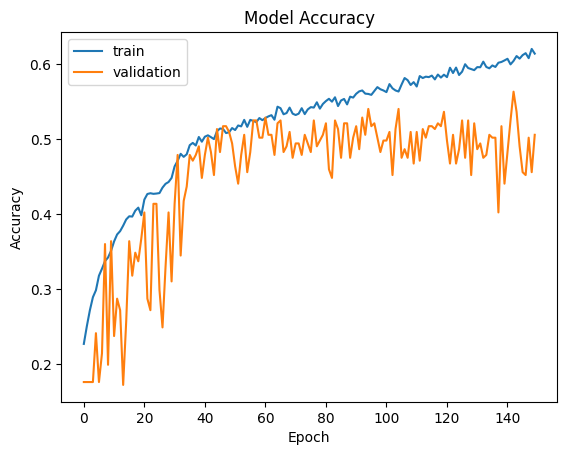

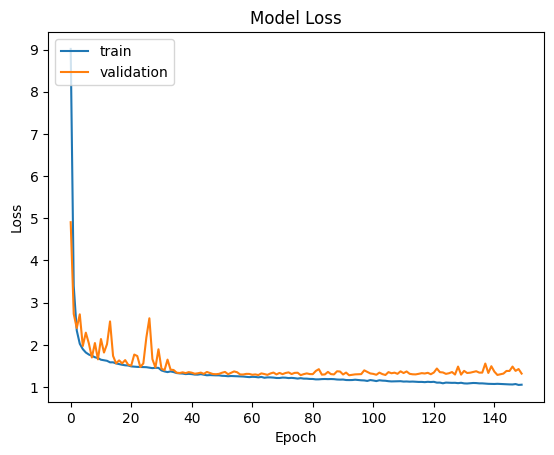

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'validation accuracy')
plt.title("Model Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

70/70 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.49      0.41      0.45       394
           1       0.49      0.69      0.57       386
           2       0.68      0.59      0.64       379
           3       0.37      0.37      0.37       371
           4       0.50      0.48      0.49       372
           5       0.59      0.56      0.58       332

    accuracy                           0.52      2234
   macro avg       0.52      0.52      0.52      2234
weighted avg       0.52      0.52      0.51      2234

val accuracy: 50.574713945388794
test accuracy 51.61145926589078


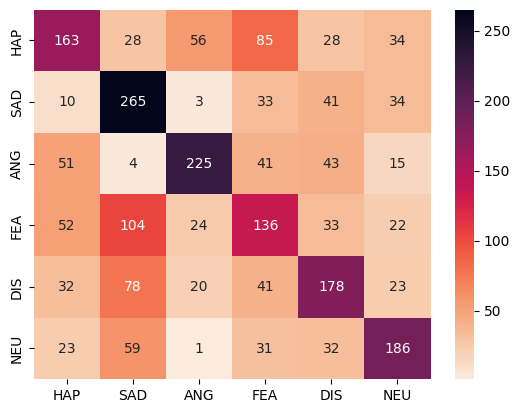

In [ ]:
y_pred = model.predict(testData)

report=metrics.classification_report(testLabels,np.argmax(y_pred,axis=1)) 
print(report)

emot = list(emotionsMap.keys())

matrix = metrics.confusion_matrix(testLabels ,np.argmax(y_pred,axis=1))
sb.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r',xticklabels = emot,yticklabels = emot)

print('val accuracy:', accuracy*100)
print("test accuracy",metrics.accuracy_score(testLabels,np.argmax(y_pred,axis=1))*100)

##2D

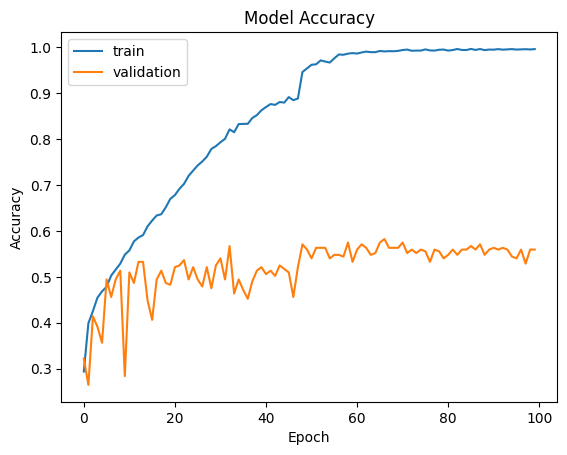

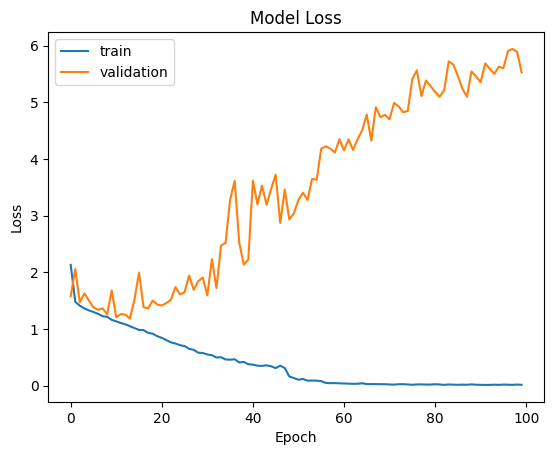

In [ ]:
plt.plot(model_history_2D.history['accuracy'], label='accuracy')
plt.plot(model_history_2D.history['val_accuracy'], label = 'validation accuracy')
plt.title("Model Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_history_2D.history['loss'])
plt.plot(model_history_2D.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

70/70 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       394
           1       0.54      0.49      0.51       386
           2       0.62      0.67      0.64       379
           3       0.43      0.40      0.42       371
           4       0.44      0.48      0.46       372
           5       0.60      0.59      0.60       332

    accuracy                           0.52      2234
   macro avg       0.52      0.52      0.52      2234
weighted avg       0.52      0.52      0.52      2234

val accuracy: 55.93869686126709
test accuracy 51.96956132497762


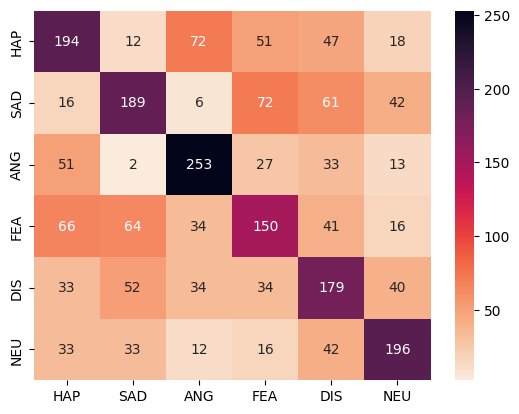

In [ ]:
y_pred = model2D.predict(twoDimTestData)

report=metrics.classification_report(twoDimTestLabels,np.argmax(y_pred,axis=1)) 
print(report)
# twoDimTrainData, twoDimTestData, twoDimTrainLabels, twoDimTestLabels
emot = list(emotionsMap.keys())

matrix = metrics.confusion_matrix(twoDimTestLabels ,np.argmax(y_pred,axis=1))
sb.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r',xticklabels = emot,yticklabels = emot)

print('val accuracy:', accuracy2D*100)
print("test accuracy",metrics.accuracy_score(twoDimTestLabels,np.argmax(y_pred,axis=1))*100)

We concluded that since the model has a really high accuracy on the training set while not so high on the validation and testing dataset then it's most likely overfitting the data.

To overcome overfitting, we tried data augmentation to add synthetic data to the dataset by 
- adding noise to a subset of the raw waveform audio
- augmenting the melspectrogram by masking some parts of the frequency and time.

In both cases the model ended up with almost the same accuarcy or worse.

The following is a snippet of the code that was used to augment the data

In [ ]:
def augment_audio(data, k):
  noise_factor = 0.1 
  stretch_factor = 0.1
  augmented_data = data.copy()[:k]
  noise = np.random.normal(0, 1, len(data[0]))
  for audio in augmented_data:
    audio = audio + noise * noise_factor
  data = np.concatenate((data, augmented_data))
  return data

def split_augment_data(x, y, k=0):
  trainData, testData, trainLabels, testLabels = train_test_split(x, y, random_state=42, test_size=0.3, shuffle=True)
  trainData, validationData, trainLabels, validationLabels = train_test_split(trainData, trainLabels, random_state=42, test_size=0.05, shuffle=True)
  if k > 0:
    trainData=augment_audio(trainData,k)
    trainLabels = np.concatenate((trainLabels, trainLabels[:k]))
  return trainData, validationData, testData, trainLabels, validationLabels, testLabels

trainData = extract_1d_features(trainData)
validationData = extract_1d_features(validationData)
testData = extract_1d_features(testData)

def spec_augment(original_melspec,
                 freq_masking_max_percentage = 0.15, 
                 time_masking_max_percentage = 0.3):

    augmented_melspec = original_melspec.copy()
    all_frames_num, all_freqs_num = augmented_melspec.shape

    # Frequency masking
    freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
    num_freqs_to_mask = int(freq_percentage * all_freqs_num)
    f0 = int(np.random.uniform(low = 0.0, high = (all_freqs_num - num_freqs_to_mask)))
    
    augmented_melspec[:, f0:(f0 + num_freqs_to_mask)] = 0

    # Time masking
    time_percentage = random.uniform(0.0, time_masking_max_percentage)
    num_frames_to_mask = int(time_percentage * all_frames_num)
    t0 = int(np.random.uniform(low = 0.0, high = (all_frames_num - num_frames_to_mask)))
    
    augmented_melspec[t0:(t0 + num_frames_to_mask), :] = 0    
    return augmented_melspec

def augment_2d(X,Y,k):
  indices = np.random.permutation(len(twoDimTrainData))[:k]
  augmented_X = X[indices].copy()
  augmented_Y = Y[indices]
  print(augmented_Y.shape)

  for xi in augmented_X:
    xi = spec_augment(xi[:,:,0])
  return augmented_X, augmented_Y

aug_twoDimTrainData, aug_twoDimTrainLabels = augment_2d(twoDimTrainData, twoDimTrainLabels, 1600)

twoDimTrainData = np.concatenate((twoDimTrainData, aug_twoDimTrainData))
twoDimTrainLabels = np.concatenate((twoDimTrainLabels, aug_twoDimTrainLabels))

print(twoDimTrainData.shape)
print(twoDimTrainLabels.shape)
